## Import libraries

In [1]:
#from tensorflow.compat.v1.keras.models import Sequential
#from tensorflow.compat.v1.keras.layers import Dense
#from tensorflow.compat.v1.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import pandas as pd
import numpy as np
from six import string_types
from six.moves import xrange as range
from numpy import nan
import xlrd

import matplotlib.pyplot as plt 
import seaborn as sns
import pylab
from pylab import *

import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, SCORERS, r2_score
from sklearn import linear_model, neighbors, tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import kendalltau, spearmanr, pearsonr, variation
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

import time
from tqdm.notebook import trange, tqdm
from time import sleep

RESULT_PATH = "results/"
FILE_PATH = 'Rect_Dataset.xlsx'

# fix random seed for reproducibility, random to be called before permutations in following blocks
seed = 4191995


## Dataset import and pre-process

In [2]:
# split into input (X) and output (Y) variables
DATA = np.array(pd.read_excel(FILE_PATH))
X = DATA[:,1:8]
Y = DATA[:,8:11]
Y = np.where(Y==0,np.nan,Y) 

#X = pd.DataFrame(X)
#print(X.info())
#Y = pd.DataFrame(Y)
#print(Y.info())

# Shuffle data
np.random.seed(seed)
p = np.random.permutation(len(X))
X = X[p]
np.random.seed(seed)
p = np.random.permutation(len(X))
Y = Y[p]

DATA = DATA[p]

# Normalize data
scaler = MinMaxScaler()
scaler.fit(X)
X_ = scaler.transform(X)


In [3]:
print((Y[:10])) # only display first 10 rows

[[3.03571429 4.96428571        nan]
 [       nan        nan 7.28346457]
 [1.21121718        nan        nan]
 [2.01284797        nan 5.2248394 ]
 [3.63961814        nan 4.85083532]
 [2.                nan 4.99696049]
 [0.625      1.25       3.125     ]
 [2.                nan 4.        ]
 [       nan        nan 9.48275862]
 [       nan        nan 4.70852018]]


In [4]:
print(X.shape)
print(Y.shape)
Z = np.zeros([X.shape[0], X.shape[1]+Y.shape[1]])
print(Z.shape)

# Combine X and Y into Z
Z[:,:7] = X[:,:]
Z[:,7:] = Y[:,:]

(82, 7)
(82, 3)
(82, 10)


## Impute Output Values

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')
imp_mean.fit(Z)
SimpleImputer()
Z_ = imp_mean.transform(Z)
print(Z_.shape)

Y_ = Z_[:,7:]
print(Y_.shape)
print(Y_[:10])  # only display first 10 rows

(82, 10)
(82, 3)
[[3.03571429 4.96428571 4.80157923]
 [0.39087948 4.48571429 7.28346457]
 [1.21121718 2.26348376 2.66375835]
 [2.01284797 4.48571429 5.2248394 ]
 [3.63961814 2.14176664 4.85083532]
 [2.         4.48571429 4.99696049]
 [0.625      1.25       3.125     ]
 [2.         4.48571429 4.        ]
 [1.99104873 4.50714286 9.48275862]
 [0.87       1.75       4.70852018]]


In [6]:
# Split into training and testing
train_all_ratio = 80/100
train_x = X_[:int(len(X)*train_all_ratio)]
test_x = X_[int(len(X)*train_all_ratio):]
test_x_original = X[int(len(X)*train_all_ratio):]
train_y = Y_[:int(len(X)*train_all_ratio)] # training targets contains inputed targets
test_y = Y[int(len(X)*train_all_ratio):] # testing targets are original targets

print('Total training data points: ', len(train_x))
print('Total testing data points: ', len(test_x))

Total training data points:  65
Total testing data points:  17


In [7]:
print(pd.DataFrame(test_y))

           0         1         2
0   3.031026       NaN       NaN
1   1.000000  2.125000  3.687500
2   0.380022       NaN  1.085776
3   2.000000       NaN       NaN
4   2.642857  4.500000       NaN
5        NaN       NaN  5.481799
6   0.583333  1.166667       NaN
7   2.450000  3.675000  4.900000
8   2.137500  2.137500  4.275000
9        NaN       NaN  9.251969
10  2.000000       NaN       NaN
11  1.333333  2.787879  4.472727
12  1.187500  1.250000  3.625000
13  1.151515  1.757576  4.993939
14  2.012848       NaN  6.852248
15  1.912500  1.912500  2.806250
16  1.107872       NaN       NaN


## Define Reference Index proc

In [8]:
#Add 4 normalized columns to array
def Ref_IDX(GSA_array, num_desc):
    r, r2, SMAPE, RMSE, ref_idx = [],[],[],[],[]
    #replace possible pearson r errors (nan) with 0
    GSA_array = np.nan_to_num(GSA_array, nan=0.0)
    #iterate through all columns and normalize metric scores
    for i in range(len(GSA_array)):
        r.append((float(GSA_array[i,num_desc+0] - min(GSA_array[:,num_desc+0]))/float(max(GSA_array[:,num_desc+0])-min(GSA_array[:,num_desc+0]))))
        r2.append(float(GSA_array[i,num_desc+1] - min(GSA_array[:,num_desc+1]))/float(max(GSA_array[:,num_desc+1])-min(GSA_array[:,num_desc+1])))
        SMAPE.append(1-float(GSA_array[i,num_desc+2] - min(GSA_array[:,num_desc+2]))/float(max(GSA_array[:,num_desc+2])-min(GSA_array[:,num_desc+2])))
        RMSE.append(1-float(GSA_array[i,num_desc+3] - min(GSA_array[:,num_desc+3]))/float(max(GSA_array[:,num_desc+3])-min(GSA_array[:,num_desc+3])))
    #concatenate variables into a single array
    r = np.vstack(r)
    r2 = np.vstack(r2)
    SMAPE = np.vstack(SMAPE)
    RMSE = np.vstack(RMSE)
    norms = np.hstack((r, r2, SMAPE, RMSE))
    GSA_array = np.hstack((GSA_array,norms))
    #average normalized values to produce reference index
    for i in range(len(GSA_array)):
        ref_idx.append(((0.1*GSA_array[i,num_desc+4])+(0.3*GSA_array[i,num_desc+5])+(0.3*GSA_array[i,num_desc+6])+(0.3*GSA_array[i,num_desc+7])))
    ref_idx = np.vstack(ref_idx)
    GSA_array = np.hstack((GSA_array,ref_idx))
    #sort array in descending order ( higher ref_idx = better performance)
    GSA_array = GSA_array[np.argsort(-GSA_array[:, num_desc+8])]
    return GSA_array

In [9]:
import warnings
warnings.filterwarnings("ignore")

## Define ML Model processing functions

In [10]:
def RemoveNan(test, pred):
    trimmed_test = []
    trimmed_pred = []
    for i in range(len(test)):
        if np.isnan(test[i]) == False:
            trimmed_test.append(test[i])
            trimmed_pred.append(pred[i])
    trimmed_test = np.array(trimmed_test, dtype='float')
    trimmed_pred = np.array(trimmed_pred, dtype='float')
    return trimmed_test, trimmed_pred

def ML_MAE(test, pred):
    MAE = 0
    for i in range(len(test)):
        MAE += abs(test[i] - pred[i])
    MAE = MAE/len(test)    
    return MAE

def ML_RMSE(test, pred):
    MSE = 0
    for i in range(len(test)):
        MSE += (test[i] - pred[i])**2
    RMSE = (MSE/len(test))**0.5
    return RMSE

def ML_SMAPE(test, pred):
    SMAPE = 0
    for i in range(len(test)):
        SMAPE += abs(test[i] - pred[i])/((abs(test[i])+abs(pred[i]))/2)
    SMAPE = (100/len(test))*SMAPE
    return SMAPE

### Establish Neural Network Model

In [11]:
def train_and_test_NN(train_X, train_Y, test_X, test_Y, neur1, neur2, neur3, activ, splits, GSA_BEST):

    activ_funcs = {1: 'sigmoid', 2: 'relu', 3: 'tanh' }
    
    # Define Sequential Keras base model
    model = Sequential()
    model.add(Dense(neur1, input_dim=7, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    if neur2 != 0: #functionality for single hidden layer grid search
        model.add(Dense(neur2, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    if neur3 != 0: #functionality for two hidden layer grid search
        model.add(Dense(neur3, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

    if splits == 0 or splits == 1: #does not perform KFold CV
            
        model.fit(train_X, train_Y, epochs=300, batch_size=8,  verbose=0)
        pred_y_nn = model.predict(test_X)
        pred_y_nn = np.hstack(pred_y_nn)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_nn)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([neur1, neur2, neur3, activ, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            model.fit(CV_train_X, CV_train_Y, epochs=300, batch_size=8,  verbose=0)
            pred_y_nn = model.predict(CV_test_X)
            pred_y_nn = np.hstack(pred_y_nn)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_nn)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([neur1, neur2, neur3, activ, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST


### Establish Linear Regression Model

In [12]:
def train_and_test_LR(train_X, train_Y, test_X, test_Y, splits, GSA_BEST):
    linear_regression = LinearRegression()

    if splits == 0 or splits == 1: #does not perform KFold CV
        linear_regression.fit(train_X, train_Y)
        pred_y_regression = linear_regression.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_regression)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            linear_regression.fit(CV_train_X, CV_train_Y)
            pred_y_regression = linear_regression.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_regression)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Ridge Regression Model

In [13]:
def train_and_test_RR(train_X, train_Y, test_X, test_Y, RR_Alpha, splits, GSA_BEST):
    RR = linear_model.Ridge(RR_Alpha)

    if splits == 0 or splits == 1: #does not perform KFold CV
        RR.fit(train_X, train_Y)
        pred_y_RR = RR.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_RR)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([RR_Alpha, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            RR.fit(CV_train_X, CV_train_Y)
            pred_y_RR = RR.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_RR)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([RR_Alpha, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Lasso Regression Model

In [14]:
def train_and_test_lasso(train_X, train_Y, test_X, test_Y, Lasso_Alpha, splits, GSA_BEST):
    Lasso = linear_model.Lasso(Lasso_Alpha)

    if splits == 0 or splits == 1: #does not perform KFold CV
        Lasso.fit(train_X, train_Y)
        pred_y_Lasso = Lasso.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_Lasso)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([Lasso_Alpha, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            Lasso.fit(CV_train_X, CV_train_Y)
            pred_y_Lasso = Lasso.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_Lasso)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([Lasso_Alpha, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish K-Nearest Neighbours Model

In [15]:
def train_and_test_KNN(train_X, train_Y, test_X, test_Y, N_neighbors, splits, GSA_BEST):
    knn = neighbors.KNeighborsRegressor(N_neighbors, weights="distance") # "uniform" or "distance"

    if splits == 0 or splits == 1: #does not perform KFold CV
        knn.fit(train_X, train_Y)
        pred_y_KNN = knn.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_KNN)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([N_neighbors, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            knn.fit(CV_train_X, CV_train_Y)
            pred_y_KNN = knn.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_KNN)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([N_neighbors, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Decision Tree Model

In [16]:
def train_and_test_DT(train_X, train_Y, test_X, test_Y, GSA_depth, splits, GSA_BEST):
    if GSA_depth == 0:
        GSA_depth = None
    DecisionTree = DecisionTreeRegressor(max_depth = GSA_depth, random_state = seed)

    if splits == 0 or splits == 1: #does not perform KFold CV
        DecisionTree.fit(train_X, train_Y)
        pred_y_DT = DecisionTree.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_DT)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([GSA_depth, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            DecisionTree.fit(CV_train_X, CV_train_Y)
            pred_y_DT = DecisionTree.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_DT)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([GSA_depth, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Random Forest Model

In [17]:
def train_and_test_RF(train_X, train_Y, test_X, test_Y, M_Bootstrap, Estimators, splits, GSA_BEST):
    RandomForest = RandomForestRegressor(n_estimators = Estimators, random_state = seed, max_samples= M_Bootstrap) 

    if splits == 0 or splits == 1: #does not perform KFold CV
        RandomForest.fit(train_X, train_Y)
        pred_y_RF = RandomForest.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_RF)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([M_Bootstrap, Estimators, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            RandomForest.fit(CV_train_X, CV_train_Y)
            pred_y_RF = RandomForest.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_RF)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([M_Bootstrap, Estimators, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Support Vector Machine Model

In [18]:
def train_and_test_SVR(train_X, train_Y, test_X, test_Y, kern, SVR_C, degr, SV_epsilon, splits, GSA_BEST):
    
    kern_funcs = {1: 'linear', 2: 'poly', 3: 'rbf', 4: 'sigmoid' }
    SVMR = SVR(kernel=kern_funcs.get(kern), C=SVR_C, gamma='auto', degree=degr, epsilon=SV_epsilon) 
    
    if splits == 0 or splits == 1: #does not perform KFold CV
        SVMR.fit(train_X, train_Y)
        pred_y_SVMR = SVMR.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_SVMR)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([kern, SVR_C, degr, SV_epsilon, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            SVMR.fit(CV_train_X, CV_train_Y)
            pred_y_SVMR = SVMR.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_SVMR)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([kern, SVR_C, degr, SV_epsilon, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

# 5-Fold CV Grid Search All Models

In [19]:
best_nn_1 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in tqdm(Neurons,desc='GSA Loop 1'): 
    for GSA_neur2 in tqdm(Neurons,desc='GSA Loop 2',leave = False):
        for GSA_neur3 in tqdm(Neurons,desc='GSA Loop 3',leave = False): 
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_1, test_y_nn_1, best_nn_1 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_1)
                
#Convert returned GSA results to np array
best_nn_1=np.vstack(best_nn_1)

#Normalize metrics and compute reference index
best_nn_1 = Ref_IDX(GSA_array = best_nn_1, num_desc = 4)    

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_1 = pd.DataFrame(best_nn_1[:3],columns = headings)
best_nn_1


NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,112.000,32.000,16.000,2.000,0.891,0.704,17.683,0.460,0.999,0.986,1.000,1.000,0.996
1,128.000,64.000,16.000,2.000,0.891,0.719,19.270,0.476,1.000,1.000,0.954,0.972,0.978
2,64.000,64.000,48.000,2.000,0.889,0.656,19.363,0.460,0.991,0.944,0.951,1.000,0.968


In [20]:
best_nn_2 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in tqdm(Neurons,desc='GSA Loop 1'): 
    for GSA_neur2 in tqdm(Neurons,desc='GSA Loop 2',leave = False):
        for GSA_neur3 in tqdm(Neurons,desc='GSA Loop 3',leave = False): 
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_2, test_y_nn_2, best_nn_2 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_2)
                
#Convert returned GSA results to np array
best_nn_2=np.vstack(best_nn_2)

#Normalize metrics and compute reference index
best_nn_2 = Ref_IDX(GSA_array = best_nn_2, num_desc = 4)     

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_2 = pd.DataFrame(best_nn_2[:3],columns = headings)
best_nn_2


NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,112.000,96.000,96.000,2.000,0.985,0.959,7.496,0.251,0.974,1.000,0.996,1.000,0.996
1,128.000,96.000,16.000,2.000,0.985,0.952,7.438,0.260,0.972,0.981,1.000,0.985,0.987
2,128.000,128.000,128.000,2.000,0.985,0.957,7.857,0.252,0.973,0.995,0.970,1.000,0.987


In [21]:
best_nn_3 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in tqdm(Neurons,desc='GSA Loop 1'): 
    for GSA_neur2 in tqdm(Neurons,desc='GSA Loop 2',leave = False):
        for GSA_neur3 in tqdm(Neurons,desc='GSA Loop 3',leave = False): 
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_3, test_y_nn_3, best_nn_3 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_3)
                
#Convert returned GSA results to np array
best_nn_3=np.vstack(best_nn_3)

#Normalize metrics and compute reference index
best_nn_3 = Ref_IDX(GSA_array = best_nn_3, num_desc = 4)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_3 = pd.DataFrame(best_nn_3[:3],columns = headings)
best_nn_3


NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,112.000,80.000,80.000,2.000,0.905,0.793,12.337,0.710,0.975,1.000,0.948,1.000,0.982
1,128.000,96.000,80.000,2.000,0.898,0.778,11.574,0.723,0.945,0.972,1.000,0.980,0.980
2,128.000,128.000,128.000,2.000,0.896,0.774,12.213,0.741,0.938,0.965,0.956,0.955,0.957


In [22]:
best_lr_1,best_lr_2, best_lr_3 = [], [], []
pred_y_lr_1, test_y_lr_1, best_lr_1  = train_and_test_LR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],splits = 5, GSA_BEST = best_lr_1)
pred_y_lr_2, test_y_lr_2, best_lr_2 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],splits = 5, GSA_BEST = best_lr_2)
pred_y_lr_3, test_y_lr_3, best_lr_3 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],splits = 5, GSA_BEST = best_lr_3)

#Convert returned GSA results to np array
best_lr_1=np.vstack(best_lr_1)
best_lr_2=np.vstack(best_lr_2)
best_lr_3=np.vstack(best_lr_3)

#Print best configuration of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['r','r2','SMAPE','RMSE']
best_lr_1 = pd.DataFrame(best_lr_1[:1],columns = headings)
print(best_lr_1)
best_lr_2 = pd.DataFrame(best_lr_2[:1],columns = headings)
print(best_lr_2)
best_lr_3 = pd.DataFrame(best_lr_3[:1],columns = headings)
print(best_lr_3)


      r    r2  SMAPE  RMSE
0 0.722 0.028 47.778 0.933
      r    r2  SMAPE  RMSE
0 0.836 0.605 19.965 0.776
      r    r2  SMAPE  RMSE
0 0.705 0.486 21.350 1.192


In [23]:
best_rr_1,best_rr_2, best_rr_3 = [], [], []
# Train and test 3 models, GSA Alpha Values from 10^-6 to 10^6
for GSA_Alpha in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]: 
    pred_y_rr_1, test_y_rr_1, best_rr_1  = train_and_test_RR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_1)
    pred_y_rr_2, test_y_rr_2, best_rr_2 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_2)
    pred_y_rr_3, test_y_rr_3, best_rr_3 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_3)
    
#Convert returned GSA results to np array
best_rr_1=np.vstack(best_rr_1)
best_rr_2=np.vstack(best_rr_2)
best_rr_3=np.vstack(best_rr_3)

#Normalize metrics and compute reference index
best_rr_1 = Ref_IDX(GSA_array = best_rr_1, num_desc = 1)    
best_rr_2 = Ref_IDX(GSA_array = best_rr_2, num_desc = 1)     
best_rr_3 = Ref_IDX(GSA_array = best_rr_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.6f}".format
headings = ['RR_Alpha','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_rr_1 = pd.DataFrame(best_rr_1[:3],columns = headings)
print(best_rr_1)
best_rr_2 = pd.DataFrame(best_rr_2[:3],columns = headings)
print(best_rr_2)
best_rr_3 = pd.DataFrame(best_rr_3[:3],columns = headings)
print(best_rr_3)

   RR_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  1.000000 0.707518 0.235137 45.282973 0.881811 0.872999 1.000000    1.000000   1.000000 0.987300
1  0.100000 0.720944 0.079489 47.466559 0.917253 0.993728 0.697376    0.822402   0.859282 0.813091
2  0.010000 0.721605 0.033977 47.742849 0.930731 0.999671 0.608889    0.799931   0.805771 0.764344
   RR_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  0.100000 0.837416 0.618067 20.158079 0.767078 1.000000 0.992495    0.990815   1.000000 0.994993
1  0.010000 0.836229 0.606760 19.970520 0.775240 0.975318 0.976463    0.999744   0.984981 0.985888
2  0.001000 0.836060 0.605293 19.965670 0.776318 0.971798 0.974383    0.999975   0.982998 0.984386
   RR_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  0.100000 0.706525 0.490099 21.085697 1.189872 1.000000 1.000000    1.000000   1.000000 1.000000
1  0.01000

In [24]:
best_lasso_1,best_lasso_2, best_lasso_3 = [], [], []
# Train and test 3 models, GSA Alpha Values from 10^-6 to 10^6
for GSA_Alpha in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]: 
    pred_y_Lasso_1, test_y_Lasso_1, best_lasso_1  = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],Lasso_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_lasso_1)
    pred_y_Lasso_2, test_y_Lasso_2, best_lasso_2 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],Lasso_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_lasso_2)
    pred_y_Lasso_3, test_y_Lasso_3, best_lasso_3 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],Lasso_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_lasso_3)
    
#Convert returned GSA results to np array
best_lasso_1=np.vstack(best_lasso_1)
best_lasso_2=np.vstack(best_lasso_2)
best_lasso_3=np.vstack(best_lasso_3)

#Normalize metrics and compute reference index
best_lasso_1 = Ref_IDX(GSA_array = best_lasso_1, num_desc = 1)    
best_lasso_2 = Ref_IDX(GSA_array = best_lasso_2, num_desc = 1)     
best_lasso_3 = Ref_IDX(GSA_array = best_lasso_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.6f}".format
headings = ['Lasso_Alpha','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_lasso_1 = pd.DataFrame(best_lasso_1[:3],columns = headings)
print(best_lasso_1)
best_lasso_2 = pd.DataFrame(best_lasso_2[:3],columns = headings)
print(best_lasso_2)
best_lasso_3 = pd.DataFrame(best_lasso_3[:3],columns = headings)
print(best_lasso_3)

   Lasso_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0     0.010000 0.709259 0.115695 47.703264 0.911353 0.982852 1.000000    0.998610   1.000000 0.997868
1     0.001000 0.720757 0.039133 47.689515 0.929147 0.998785 0.806121    1.000000   0.919965 0.917704
2     0.000100 0.721560 0.029189 47.766580 0.932170 0.999898 0.780939    0.992207   0.906367 0.903843
   Lasso_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0     0.010000 0.837802 0.615459 20.129372 0.768822 0.990291 1.000000    0.992189   1.000000 0.996686
1     0.001000 0.836110 0.606855 19.984053 0.775174 0.988290 0.987662    0.999107   0.988274 0.991342
2     0.000100 0.836044 0.605292 19.966876 0.776318 0.988212 0.985421    0.999925   0.986163 0.990274
   Lasso_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0     0.001000 0.704021 0.485841 21.272412 1.192719 0.999320 0.999388    0.985723 

In [25]:
best_knn_1,best_knn_2, best_knn_3 = [], [], []
# Train and test 3 models, GSA Neighbour Amounts from 2 to 25
for GSA_NN in range(2,26): 
    pred_y_knn_1, test_y_knn_1,best_knn_1 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_1 )
    pred_y_knn_2, test_y_knn_2,best_knn_2 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_2 )
    pred_y_knn_3, test_y_knn_3,best_knn_3 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_3 )

#Convert returned GSA results to np array
best_knn_1=np.vstack(best_knn_1)
best_knn_2=np.vstack(best_knn_2)
best_knn_3=np.vstack(best_knn_3)

#Normalize metrics and compute reference index
best_knn_1 = Ref_IDX(GSA_array = best_knn_1, num_desc = 1)    
best_knn_2 = Ref_IDX(GSA_array = best_knn_2, num_desc = 1)     
best_knn_3 = Ref_IDX(GSA_array = best_knn_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['#NN','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_knn_1 = pd.DataFrame(best_knn_1[:3],columns = headings)
print(best_knn_1)
best_knn_2 = pd.DataFrame(best_knn_2[:3],columns = headings)
print(best_knn_2)
best_knn_3 = pd.DataFrame(best_knn_3[:3],columns = headings)
print(best_knn_3)

    #NN     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000 0.744 0.313 31.655 0.874   1.000    0.887       0.810      0.868  0.870
1 8.000 0.733 0.355 36.780 0.860   0.795    0.977       0.532      0.969  0.823
2 7.000 0.725 0.340 35.284 0.869   0.657    0.945       0.613      0.906  0.805
    #NN     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 3.000 0.964 0.922 10.076 0.346   1.000    1.000       1.000      1.000  1.000
1 2.000 0.954 0.900 10.496 0.391   0.868    0.916       0.964      0.883  0.916
2 4.000 0.956 0.896 11.085 0.395   0.901    0.903       0.913      0.874  0.897
    #NN     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000 0.804 0.561 17.387 1.044   1.000    0.946       1.000      1.000  0.984
1 7.000 0.803 0.571 18.401 1.047   0.979    1.000       0.828      0.988  0.943
2 6.000 0.799 0.560 18.013 1.049   0.928    0.940       0.894      0.973  0.935


In [26]:
best_dt_1,best_dt_2, best_dt_3 = [], [], []
# Train and test 3 models, GSA max_depths Amounts from 0 (None) to 10
for Depths in range(0,11): 
    pred_y_dt_1, test_y_dt_1,best_dt_1 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_1 )
    pred_y_dt_2, test_y_dt_2,best_dt_2 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_2 )
    pred_y_dt_3, test_y_dt_3,best_dt_3 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_3 )

#Convert returned GSA results to np array
best_dt_1=np.vstack(best_dt_1)
best_dt_2=np.vstack(best_dt_2)
best_dt_3=np.vstack(best_dt_3)

#Normalize metrics and compute reference index
best_dt_1 = Ref_IDX(GSA_array = best_dt_1, num_desc = 1)    
best_dt_2 = Ref_IDX(GSA_array = best_dt_2, num_desc = 1)     
best_dt_3 = Ref_IDX(GSA_array = best_dt_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['Max_Depth','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_dt_1 = pd.DataFrame(best_dt_1[:3],columns = headings)
print(best_dt_1)
best_dt_2 = pd.DataFrame(best_dt_2[:3],columns = headings)
print(best_dt_2)
best_dt_3 = pd.DataFrame(best_dt_3[:3],columns = headings)
print(best_dt_3)

  Max_Depth     r     r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0      None 0.619 -0.580 34.341 1.115  0.668   0.071      0.951     0.251 0.449
1     1.000   NaN -0.539 57.714 1.173    NaN   0.156      0.000     0.000   NaN
2     4.000 0.678 -0.133 33.129 0.945  1.000   1.000      1.000     1.000 1.000
  Max_Depth     r    r2 SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     7.000 0.966 0.927 9.502 0.327  1.000   1.000      0.930     1.000 0.979
1     8.000 0.965 0.924 9.550 0.341  0.912   0.844      0.909     0.706 0.829
2     9.000 0.964 0.922 9.468 0.347  0.857   0.765      0.945     0.588 0.775
  Max_Depth     r    r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     6.000 0.731 0.256 20.716 1.297  1.000   0.897      1.000     0.930 0.948
1     3.000 0.708 0.306 22.486 1.260  0.950   1.000      0.820     1.000 0.941
2     4.000 0.712 0.256 21.740 1.272  0.959   0.897      0.896     0.977 0.927


In [27]:
best_rf_1,best_rf_2, best_rf_3 = [], [], []
# Train and test 3 models, GSA Tree amount Values from 50 to 1500, m values = 2,3,4,5

m_values = range(1,6)
tree_amounts = range(50,1050,50)

for GSA_m in tqdm(m_values,desc='GSA Loop 1'): 
    for GSA_trees in tqdm(tree_amounts,desc='GSA Loop 2',leave = False): 
        pred_y_rf_1, test_y_rf_1, best_rf_1 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_1)
        pred_y_rf_2, test_y_rf_2, best_rf_2 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_2)
        pred_y_rf_3, test_y_rf_3, best_rf_3 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_3)
    
#Convert returned GSA results to np array
best_rf_1=np.vstack(best_rf_1)
best_rf_2=np.vstack(best_rf_2)
best_rf_3=np.vstack(best_rf_3)

#Normalize metrics and compute reference index
best_rf_1 = Ref_IDX(GSA_array = best_rf_1, num_desc = 2)    
best_rf_2 = Ref_IDX(GSA_array = best_rf_2, num_desc = 2)     
best_rf_3 = Ref_IDX(GSA_array = best_rf_3, num_desc = 2)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['m','Trees','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_rf_1 = pd.DataFrame(best_rf_1[:3],columns = headings)
print(best_rf_1)
best_rf_2 = pd.DataFrame(best_rf_2[:3],columns = headings)
print(best_rf_2)
best_rf_3 = pd.DataFrame(best_rf_3[:3],columns = headings)
print(best_rf_3)


      m   Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000 150.000 0.648 0.102 50.318 0.969   0.913    1.000       1.000      0.998  0.991
1 5.000 350.000 0.687 0.092 50.796 0.969   0.968    0.974       0.939      1.000  0.971
2 5.000 100.000 0.626 0.093 50.533 0.975   0.883    0.976       0.972      0.961  0.961
      m   Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000  50.000 0.945 0.707 20.722 0.677   1.000    1.000       1.000      1.000  1.000
1 5.000 100.000 0.936 0.689 21.459 0.699   0.990    0.978       0.964      0.966  0.971
2 5.000 150.000 0.935 0.666 22.446 0.725   0.989    0.950       0.916      0.924  0.936
      m   Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000  50.000 0.660 0.258 25.524 1.443   0.941    1.000       1.000      1.000  0.994
1 4.000  50.000 0.701 0.224 26.482 1.466   1.000    0.914       0.878      0.930  0.917
2 5.000 100.000 0.677 0.220 26.

In [41]:
best_svmr_1,best_svmr_2, best_svmr_3 = [], [], []
# Train and test 3 models, Various GSA parameters (This takes a while)
Kernels = list(range(1,5)) #see dictionary definition in above function.
C_list = [*range(1,11)] + [*range(50,1050,50)]
Degrees = list(range(3,6))
Epsilons = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

for GSA_kern in Kernels: 
    for GSA_C in C_list: 
        for GSA_degr in Degrees: 
            for GSA_eps in Epsilons: 
                if GSA_kern != 2 and GSA_degr != 5:
                    continue
                pred_y_svmr_1, test_y_svmr_1, best_svmr_1 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_1)
                pred_y_svmr_2, test_y_svmr_2, best_svmr_2 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_2)
                pred_y_svmr_3, test_y_svmr_3, best_svmr_3 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_3)
                
#Convert returned GSA results to np array
best_svmr_1=np.vstack(best_svmr_1)
best_svmr_2=np.vstack(best_svmr_2)
best_svmr_3=np.vstack(best_svmr_3)

#Normalize metrics and compute reference index
best_svmr_1 = Ref_IDX(GSA_array = best_svmr_1, num_desc = 4)    
best_svmr_2 = Ref_IDX(GSA_array = best_svmr_2, num_desc = 4)     
best_svmr_3 = Ref_IDX(GSA_array = best_svmr_3, num_desc = 4)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.5f}".format
headings = ['Kern', 'C', 'degr', 'eps','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_svmr_1 = pd.DataFrame(best_svmr_1[:3],columns = headings)
print(best_svmr_1)
best_svmr_2 = pd.DataFrame(best_svmr_2[:3],columns = headings)
print(best_svmr_2)
best_svmr_3 = pd.DataFrame(best_svmr_3[:3],columns = headings)
print(best_svmr_3)

     Kern         C    degr     eps       r       r2    SMAPE    RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE   INDEX
0 3.00000 800.00000 5.00000 0.00010 0.75162 -0.03856 32.45958 0.91088 0.95994  0.99298     0.99917    0.97738 0.98685
1 3.00000 800.00000 5.00000 0.00001 0.75156 -0.03865 32.46867 0.91092 0.95988  0.99297     0.99907    0.97738 0.98681
2 3.00000 850.00000 5.00000 0.00001 0.75102 -0.05551 32.39046 0.91408 0.95936  0.99276     0.99992    0.97691 0.98681
     Kern        C    degr     eps       r      r2    SMAPE    RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE   INDEX
0 3.00000 50.00000 5.00000 0.10000 0.94903 0.87645 12.77880 0.43980 0.99964  1.00000     0.99889    0.99992 0.99961
1 3.00000 50.00000 5.00000 0.00010 0.94573 0.87397 12.67780 0.44574 0.99617  0.99994     1.00000    0.99914 0.99934
2 3.00000 50.00000 5.00000 0.00001 0.94571 0.87396 12.67784 0.44575 0.99615  0.99994     1.00000    0.99914 0.99934
     Kern         C    degr     eps       r      r2    SMAPE    

## Optimal Model Configurations

In [19]:
best_nn_1,best_nn_2, best_nn_3 = [], [], []
pred_y_nn_1, test_y_nn_1, best_nn_1 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], neur1 = 112, neur2 = 32, neur3 = 16, activ = 2, splits = 1, GSA_BEST = best_nn_1)
pred_y_nn_2, test_y_nn_2, best_nn_2 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], neur1 = 112, neur2 = 96, neur3 = 96, activ = 2, splits = 1, GSA_BEST = best_nn_2)
pred_y_nn_3, test_y_nn_3, best_nn_3 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], neur1 = 112, neur2 = 80, neur3 = 80, activ = 2, splits = 1, GSA_BEST = best_nn_3)
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE']
best_nn_1 = pd.DataFrame(best_nn_1,columns = headings)
best_nn_2 = pd.DataFrame(best_nn_2,columns = headings)
best_nn_3 = pd.DataFrame(best_nn_3,columns = headings)

best_lr_1,best_lr_2, best_lr_3 = [], [], []
pred_y_lr_1, test_y_lr_1, best_lr_1  = train_and_test_LR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],splits = 1, GSA_BEST = best_lr_1)
pred_y_lr_2, test_y_lr_2, best_lr_2 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],splits = 1, GSA_BEST = best_lr_2)
pred_y_lr_3, test_y_lr_3, best_lr_3 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],splits = 1, GSA_BEST = best_lr_3)
headings = ['r','r2','SMAPE','RMSE']
best_lr_1 = pd.DataFrame(best_lr_1,columns = headings)
best_lr_2 = pd.DataFrame(best_lr_2,columns = headings)
best_lr_3 = pd.DataFrame(best_lr_3,columns = headings)

best_rr_1,best_rr_2, best_rr_3 = [], [], []
pred_y_rr_1, test_y_rr_1, best_rr_1 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],RR_Alpha = 1.000000, splits = 1, GSA_BEST = best_rr_1)
pred_y_rr_2, test_y_rr_2, best_rr_2 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],RR_Alpha = 0.100000, splits = 1, GSA_BEST = best_rr_2)
pred_y_rr_3, test_y_rr_3, best_rr_3 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],RR_Alpha = 0.100000 , splits = 1, GSA_BEST = best_rr_3)
headings = ['RR_Alpha','r','r2','SMAPE','RMSE']
best_rr_1 = pd.DataFrame(best_rr_1,columns = headings)
best_rr_2 = pd.DataFrame(best_rr_2,columns = headings)
best_rr_3 = pd.DataFrame(best_rr_3,columns = headings)

best_lasso_1,best_lasso_2, best_lasso_3 = [], [], []
pred_y_Lasso_1, test_y_Lasso_1, best_lasso_1  = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],Lasso_Alpha = 0.010000  , splits = 1, GSA_BEST = best_lasso_1)
pred_y_Lasso_2, test_y_Lasso_2, best_lasso_2 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],Lasso_Alpha = 0.010000  , splits = 1, GSA_BEST = best_lasso_2)
pred_y_Lasso_3, test_y_Lasso_3, best_lasso_3 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],Lasso_Alpha = 0.001000  , splits = 1, GSA_BEST = best_lasso_3)
headings = ['Lasso_Alpha','r','r2','SMAPE','RMSE']
best_lasso_1 = pd.DataFrame(best_lasso_1,columns = headings)
best_lasso_2 = pd.DataFrame(best_lasso_2,columns = headings)
best_lasso_3 = pd.DataFrame(best_lasso_3,columns = headings)

best_knn_1,best_knn_2, best_knn_3 = [], [], []
pred_y_knn_1, test_y_knn_1,best_knn_1 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], N_neighbors = 5, splits = 1, GSA_BEST = best_knn_1 )
pred_y_knn_2, test_y_knn_2,best_knn_2 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], N_neighbors = 3, splits = 1, GSA_BEST = best_knn_2 )
pred_y_knn_3, test_y_knn_3,best_knn_3 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], N_neighbors = 5, splits = 1, GSA_BEST = best_knn_3 )
headings = ['# NN','r','r2','SMAPE','RMSE']
best_knn_1 = pd.DataFrame(best_knn_1,columns = headings)
best_knn_2 = pd.DataFrame(best_knn_2,columns = headings)
best_knn_3 = pd.DataFrame(best_knn_3,columns = headings)

best_dt_1,best_dt_2, best_dt_3 = [], [], []
pred_y_dt_1, test_y_dt_1,best_dt_1 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GSA_depth = 4, splits = 1, GSA_BEST = best_dt_1 )
pred_y_dt_2, test_y_dt_2,best_dt_2 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GSA_depth = 7, splits = 1, GSA_BEST = best_dt_2 )
pred_y_dt_3, test_y_dt_3,best_dt_3 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GSA_depth = 6, splits = 1, GSA_BEST = best_dt_3 )
headings = ['Max_Depth','r','r2','SMAPE','RMSE']
best_dt_1 = pd.DataFrame(best_dt_1[:5],columns = headings)
best_dt_2 = pd.DataFrame(best_dt_2[:5],columns = headings)
best_dt_3 = pd.DataFrame(best_dt_3[:5],columns = headings)

best_rf_1,best_rf_2, best_rf_3 = [], [], []
pred_y_rf_1, test_y_rf_1, best_rf_1 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],M_Bootstrap = 5, Estimators = 150, splits = 1, GSA_BEST = best_rf_1)
pred_y_rf_2, test_y_rf_2, best_rf_2 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],M_Bootstrap = 5, Estimators = 50, splits = 1, GSA_BEST = best_rf_2)
pred_y_rf_3, test_y_rf_3, best_rf_3 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],M_Bootstrap = 5, Estimators = 50, splits = 1, GSA_BEST = best_rf_3)
headings = ['m','# Estimators','r','r2','SMAPE','RMSE']
best_rf_1 = pd.DataFrame(best_rf_1,columns = headings)
best_rf_2 = pd.DataFrame(best_rf_2,columns = headings)
best_rf_3 = pd.DataFrame(best_rf_3,columns = headings)

best_svmr_1,best_svmr_2, best_svmr_3 = [], [], []
pred_y_svmr_1, test_y_svmr_1, best_svmr_1 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], kern = 3, SVR_C = 800, degr = 5, SV_epsilon = 0.00010, splits = 1, GSA_BEST = best_svmr_1)
pred_y_svmr_2, test_y_svmr_2, best_svmr_2 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], kern = 3, SVR_C = 50, degr = 5, SV_epsilon = 0.10000, splits = 1, GSA_BEST = best_svmr_2)
pred_y_svmr_3, test_y_svmr_3, best_svmr_3 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], kern = 3, SVR_C = 300, degr = 5, SV_epsilon = 0.00001, splits = 1, GSA_BEST = best_svmr_3)
headings = ['Kern', 'C', 'degr', 'eps','r','r2','SMAPE','RMSE']
best_svmr_1 = pd.DataFrame(best_svmr_1[:5],columns = headings)
best_svmr_2 = pd.DataFrame(best_svmr_2[:5],columns = headings)
best_svmr_3 = pd.DataFrame(best_svmr_3[:5],columns = headings)


## Split test inputs and outputs for clarity in following tables

In [20]:
test_y_1, test_y_2, test_y_3 = [], [], []
test_x_original_1, test_x_original_2, test_x_original_3 = pd.DataFrame(test_x_original), pd.DataFrame(test_x_original), pd.DataFrame(test_x_original)

for i in range(len(test_y)):
    if np.isnan(test_y[:,0][i]) == False:
        test_y_1.append(test_y[:,0][i])
    else:
        test_x_original_1 = test_x_original_1.drop(labels = i, axis = 0)
    if np.isnan(test_y[:,1][i]) == False:
        test_y_2.append(test_y[:,1][i])
    else:
        test_x_original_2 = test_x_original_2.drop(labels = i, axis = 0)
    if np.isnan(test_y[:,2][i]) == False:
        test_y_3.append(test_y[:,2][i])
    else:
        test_x_original_3 = test_x_original_3.drop(labels = i, axis = 0)
test_y_1 = np.array(test_y_1)
test_y_2 = np.array(test_y_2)
test_y_3 = np.array(test_y_3)    

## Define Normalizing func for results

In [21]:
#Add 4 normalized columns to array
def Norm(Array):
    norm_array = []
    #iterate through column and normalize metric scores
    for i in range(len(Array)):
        norm_array.append((Array[i]-min(Array))/(max(Array)-min(Array)))
    #Force list
    norm_array = list(norm_array)
    return norm_array

def Norm_inv(Array):
    invnorm_array = []
    #iterate through column and normalize metric scores
    for i in range(len(Array)):
        invnorm_array.append(1-((Array[i]-min(Array))/(max(Array)-min(Array))))
    #Force list
    invnorm_array = list(invnorm_array)
    return invnorm_array

def List_AVG(var1, var2, var3, var4):
    AVG = []
    #iterate through column and normalize metric scores
    for i in range(len(var1)):
        AVG.append((0.1*var1[i])+(0.3*var2[i])+(0.3*var3[i])+(0.3*var4[i]))
    #Force list
    AVG = list(AVG)
    return AVG

## Print Core Crushing Results

In [22]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[8])
head.append("ANN Prediction")
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("Lasso Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("Support Vector Prediction")
result.append(head[1:])

for i in range(len(test_y_1)):
    tmp = list(test_x_original_1.to_numpy()[i])
    tmp.append(test_y_1[i])
    tmp.append(pred_y_nn_1[i])
    tmp.append(pred_y_lr_1[i])
    tmp.append(pred_y_rr_1[i])
    tmp.append(pred_y_Lasso_1[i])
    tmp.append(pred_y_knn_1[i])
    tmp.append(pred_y_dt_1[i])
    tmp.append(pred_y_rf_1[i])
    tmp.append(pred_y_svmr_1[i])    
    result.append(tmp)
result = pd.DataFrame(result)

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Trans (%),Core Crushing Drift (%),ANN Prediction,Linear Regression Prediction,Ridge Regression Prediction,Lasso Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,Support Vector Prediction
1,0.195,29.4,5.49508,429,1.63,392,1.5,3.03103,2.52331,2.10151,1.96764,1.96378,2.91631,2.85327,1.87647,1.99281
2,0.2,25.6,4,474,1.57,333,2.5,1,1.46938,1.34021,1.40159,1.26803,1.125,1.03722,1.68687,0.999918
3,0.47,102.2,6.03934,454,2.58,463,4.3,0.380022,0.363691,0.0580147,0.446932,0.298937,0.30741,0.406205,1.3487,0.321095
4,0.462,34,4.7,455.6,2.93,580,1.3,2,2.46504,1.99869,1.8724,1.93807,2,1.82714,1.7928,2.04418
5,0.111,25.3,3.5,497,2.14,459.5,0,2.64286,3.2087,2.75207,2.59742,2.64464,2.94946,2.85327,2.47058,2.756
6,0.42,21.4,2.18182,375,1.79,297,2,0.583333,0.666715,0.346644,0.624446,0.51995,0.749,1.15422,1.55884,0.703581
7,0.1,46.5,4,446,1.51,364,0.9,2.45,1.98001,1.9901,1.99319,1.98678,2.07886,1.63396,1.89717,1.58961
8,0.3,44,4,446,1.51,360,1.2,2.1375,0.97268,1.39135,1.46579,1.41426,1.5459,1.15422,1.53542,0.978124
9,0.462,34,4.7,427.8,3.28,570,2.7,2,2.04189,1.43945,1.43076,1.44711,2,2,1.4838,2.11763


## Print Concrete Spalling Results

In [23]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[9])
head.append("ANN Prediction")
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("Lasso Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("Support Vector Prediction")
result.append(head[1:])

for i in range(len(test_y_2)):
    tmp = list(test_x_original_2.to_numpy()[i])
    tmp.append(test_y_2[i])
    tmp.append(pred_y_nn_2[i])
    tmp.append(pred_y_lr_2[i])
    tmp.append(pred_y_rr_2[i])
    tmp.append(pred_y_Lasso_2[i])
    tmp.append(pred_y_knn_2[i])
    tmp.append(pred_y_dt_2[i])
    tmp.append(pred_y_rf_2[i])
    tmp.append(pred_y_svmr_2[i])    
    result.append(tmp)
result = pd.DataFrame(result)

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Trans (%),Concrete Spalling Drift (%),ANN Prediction,Linear Regression Prediction,Ridge Regression Prediction,Lasso Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,Support Vector Prediction
1,0.2,25.6,4,474,1.57,333,2.5,2.125,2.4366,2.8359,2.82574,2.71161,2.20833,2.0596,2.81316,2.13146
2,0.111,25.3,3.5,497,2.14,459.5,0,4.5,5.03276,4.05191,4.03459,3.97093,4.92399,4.96429,3.98751,4.45062
3,0.42,21.4,2.18182,375,1.79,297,2,1.16667,1.71103,1.55836,1.59027,1.69974,1.44932,1.75,2.54306,1.13392
4,0.1,46.5,4,446,1.51,364,0.9,3.675,2.98611,2.31467,2.36682,2.50576,2.90736,2.0596,2.93701,2.67524
5,0.3,44,4,446,1.51,360,1.2,2.1375,2.98438,2.31495,2.36005,2.49312,3.32483,1.99866,2.91904,2.5469
6,0.1,32,3,511,1.25,325,1.7,2.78788,2.1966,2.66201,2.6822,2.70445,1.93939,1.9072,2.91815,2.03958
7,0.21,25,4,427,1.51,280,2.2,1.25,1.29915,1.96055,1.98314,1.96374,1.78743,1.75,2.76921,1.30553
8,0.3,32.1,3,511,1.25,325,2.1,1.75758,2.13984,2.66455,2.67938,2.70412,1.51515,1.52633,2.90364,1.81399
9,0.3,44,4,446,1.51,364,0.8,1.9125,2.97809,2.30383,2.35479,2.51408,3.24438,1.99866,2.92081,2.61527


## Print Bar Buckling Results

In [24]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[10])
head.append("ANN Prediction")
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("Lasso Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("Support Vector Prediction")
result.append(head[1:])

for i in range(len(test_y_3)):
    tmp = list(test_x_original_3.to_numpy()[i])
    tmp.append(test_y_3[i])
    tmp.append(pred_y_nn_3[i])
    tmp.append(pred_y_lr_3[i])
    tmp.append(pred_y_rr_3[i])
    tmp.append(pred_y_Lasso_3[i])
    tmp.append(pred_y_knn_3[i])
    tmp.append(pred_y_dt_3[i])
    tmp.append(pred_y_rf_3[i])
    tmp.append(pred_y_svmr_3[i])    
    result.append(tmp)
result = pd.DataFrame(result)

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Trans (%),Bar Buckling Drift (%),ANN Prediction,Linear Regression Prediction,Ridge Regression Prediction,Lasso Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,Support Vector Prediction
1,0.2,25.6,4,474,1.57,333,2.5,3.6875,5.10979,5.32774,5.27423,5.31284,5.98333,5.98333,4.62504,5.00029
2,0.47,102.2,6.03934,454,2.58,463,4.3,1.08578,1.54435,2.36554,2.47504,2.38912,1.95131,1.87296,4.01739,1.73266
3,0.232,28.1,3.82787,448,2.22,428,0.5,5.4818,4.69212,4.87744,4.88688,4.87805,5.13209,4.41623,4.29228,4.81188
4,0.1,46.5,4,446,1.51,364,0.9,4.9,2.33709,3.94588,4.0034,3.96184,4.20552,5.53839,4.4092,3.91204
5,0.3,44,4,446,1.51,360,1.2,4.275,3.11218,3.71974,3.76967,3.73667,3.82768,3.03189,3.94911,4.25272
6,0.1,76,2,510,3.55,510,3.7,9.25197,8.24905,6.8319,6.81578,6.81072,7.23424,7.87402,5.63946,8.66667
7,0.1,32,3,511,1.25,325,1.7,4.47273,3.32124,5.98526,5.95206,5.97932,4.07273,4.66648,4.99118,4.07271
8,0.21,25,4,427,1.51,280,2.2,3.625,3.50151,4.06366,4.06341,4.0613,5.1477,4.41623,3.96721,4.1175
9,0.3,32.1,3,511,1.25,325,2.1,4.99394,4.44931,5.71457,5.67511,5.70999,4.72727,4.66648,4.56183,4.81236


## Create Polar Graphs for Manuscript

Best Concrete Spalling Model: SVMR
Best Core Crushing Model: KNN
Best Bar Buckling Model: SVMR


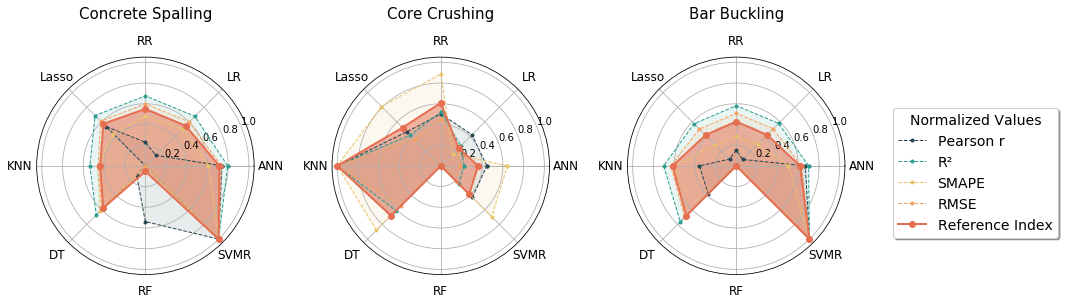

In [80]:
labels=np.array(['ANN', 'LR', 'RR', 'Lasso', 'KNN', 'DT', 'RF', 'SVMR'])
models = {0:'ANN',1: 'LR',2: 'RR',3: 'Lasso',4: 'KNN',5: 'DT',6: 'RF',7: 'SVMR'}
best_1, best_2, best_3 = [],[],[]
best_model = {0: best_1,1: best_2,2: best_3}
title_lbl= {1:'Core Crushing', 0:'Concrete Spalling', 2:'Bar Buckling'}
legend_lbl=np.array(['Pearson r','R²','SMAPE','RMSE','Reference Index'])
varlist_1= {0:best_nn_1, 1:best_lr_1, 2:best_rr_1, 3:best_lasso_1, 4:best_knn_1, 5:best_dt_1, 6:best_rf_1, 7:best_svmr_1}
varlist_2= {0:best_nn_2, 1:best_lr_2, 2:best_rr_2, 3:best_lasso_2, 4:best_knn_2, 5:best_dt_2, 6:best_rf_2, 7:best_svmr_2}
varlist_3= {0:best_nn_3, 1:best_lr_3, 2:best_rr_3, 3:best_lasso_3, 4:best_knn_3, 5:best_dt_3, 6:best_rf_3, 7:best_svmr_3}
list_of_lists= {0:varlist_2, 1:varlist_1, 2:varlist_3}

palette = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(15,4))

for i in range(len(list_of_lists)):
    plt_title = title_lbl.get(i) 
    radial_r, radial_r2, radial_SMAPE, radial_RMSE, radial_RefIDX = [], [], [], [], []
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    for j in range(len(list_of_lists[i])):
        radial_r.append(list_of_lists[i][j].at[0,'r'])
        radial_r2.append(list_of_lists[i][j].at[0,'r2'])
        radial_SMAPE.append(list_of_lists[i][j].at[0,'SMAPE'])
        radial_RMSE.append(list_of_lists[i][j].at[0,'RMSE'])    

    angles=np.concatenate((angles,[angles[0]]))
    radial_r=np.concatenate((radial_r,[radial_r[0]]))
    radial_r2=np.concatenate((radial_r2,[radial_r2[0]]))
    radial_SMAPE=np.concatenate((radial_SMAPE,[radial_SMAPE[0]]))
    radial_RMSE=np.concatenate((radial_RMSE,[radial_RMSE[0]]))
    radial_r = Norm(radial_r)
    radial_r2 = Norm(radial_r2)
    radial_SMAPE = Norm_inv(radial_SMAPE)
    radial_RMSE = Norm_inv(radial_RMSE)
    radialplt= {0:radial_r, 1:radial_r2, 2:radial_SMAPE, 3:radial_RMSE}
    radial_RefIDX = List_AVG(radial_r, radial_r2, radial_SMAPE, radial_RMSE)
    for j in range(len(radialplt)):
        ax[i].plot(angles, radialplt[j], marker = '.', ls = '--', lw = 1, alpha=1)
        ax[i].fill(angles, radialplt[j], alpha=0.1)
    
    ax[i].plot(angles, radial_RefIDX, 'o-', alpha=1, lw = 2)
    ax[i].fill(angles, radial_RefIDX, alpha=.5)
    ax[i].set_thetagrids(angles * 180/np.pi, labels, fontsize = 12, y =-.025)
    ax[i].set_title(plt_title, fontsize = 15, y=1.15)
    best_model[i] = (radial_RefIDX[:8])
    print("Best",title_lbl[i], "Model:",models.get(best_model[i].index(max(best_model[i]))))
ax[2].legend(legend_lbl,title="Normalized Values", title_fontsize = 14,loc='upper center', bbox_to_anchor=(1.6, 0.8), shadow=True, ncol=1,fontsize = 14)


## Create Scatter Plots for Manuscript

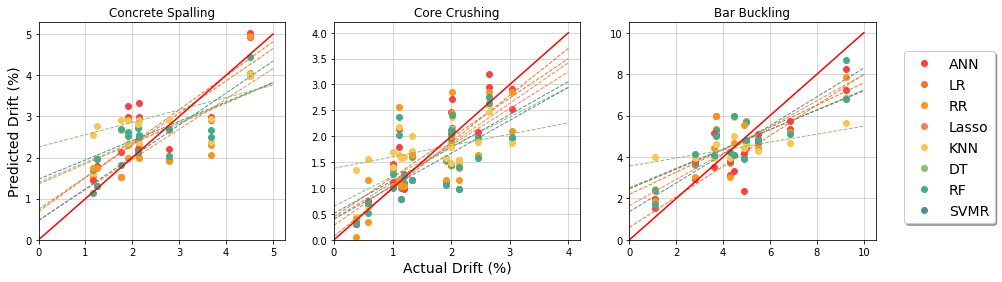

In [87]:
legend_lbl=np.array(['ANN', 'LR', 'RR', 'Lasso', 'KNN', 'DT', 'RF', 'SVMR'])
title_lbl= {0:'Concrete Spalling', 1:'Core Crushing', 2:'Bar Buckling'}

y_list_1= {0:pred_y_nn_1, 1:pred_y_lr_1, 2:pred_y_rr_1, 3:pred_y_Lasso_1, 4:pred_y_knn_1, 5:pred_y_dt_1, 6:pred_y_rf_1, 7:pred_y_svmr_1}
y_list_2= {0:pred_y_nn_2, 1:pred_y_lr_2, 2:pred_y_rr_2, 3:pred_y_Lasso_2, 4:pred_y_knn_2, 5:pred_y_dt_2, 6:pred_y_rf_2, 7:pred_y_svmr_2}
y_list_3= {0:pred_y_nn_3, 1:pred_y_lr_3, 2:pred_y_rr_3, 3:pred_y_Lasso_3, 4:pred_y_knn_3, 5:pred_y_dt_3, 6:pred_y_rf_3, 7:pred_y_svmr_3}
perf_fit = [[0,5],[0,4],[0,10]]
x_list= {0:test_y_2, 1:test_y_1, 2:test_y_3}
y_all= {0:y_list_2, 1:y_list_1, 2:y_list_3}

palette = ["#F94144", "#F3722C", "#F8961E", "#F9844A", "#F9C74F", "#90BE6D", "#43AA8B", "#4D908E"]
sns.set_palette(palette)
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(15,4))
lgnd_h = []
for i in range(len(y_all)):
    plt_title = title_lbl.get(i) 
    for j in range(len(labels)):
        ax[i].plot(x_list.get(i),y_all.get(i).get(j), marker = 'o', lw = 0)
        if i == 0:
            lgnd_h.append(Line2D(x_list.get(i),y_all.get(i).get(j), marker = 'o', color= palette[j], lw = 0))
        # Display Linear Trendline for each series
        trend_x = np.polyfit(x_list.get(i), y_all.get(i).get(j), 1)
        trend_fit = np.poly1d(trend_x)
        ax[i].plot([0,perf_fit[i][1]],[trend_fit(0),trend_fit(perf_fit[i][1])],ls = '--',lw = 1)
    ax[i].plot(perf_fit[i],perf_fit[i], 'r-', lw = 1.5)
    ax[i].set_title(plt_title, y=1, fontsize = 12)
    ax[i].set_ylim(bottom=0); ax[i].set_xlim(left=0)
    ax[i].grid(linestyle='-', linewidth=0.5)
ax[0].set_ylabel('Predicted Drift (%)', fontsize=14)
ax[1].set_xlabel('Actual Drift (%)', fontsize=14)
ax[2].legend(handles =lgnd_h, labels = list(legend_lbl), loc='upper center', bbox_to_anchor=(1.3, .9), shadow=True, ncol=1, fontsize = 14)

## Plot Histograms for Manuscript

Text(0.5, 0, 'Drift Ratio (%) \n(c)')

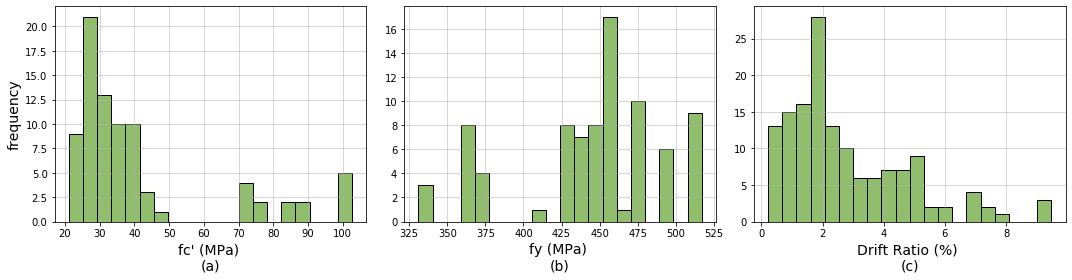

In [49]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(15,4))
n_bins = 20
ax[0].grid(linestyle='-', linewidth=0.5)
ax[0].hist(X[:,1], bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[0].set_xlabel("fc' (MPa) \n(a)", fontsize=14)
ax[0].set_ylabel("frequency", fontsize=14)

ax[1].grid(linestyle='-', linewidth=0.5)
ax[1].hist(X[:,3], bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[1].set_xlabel("fy (MPa) \n(b)", fontsize=14)

ax[2].grid(linestyle='-', linewidth=0.5)
Hist_Y = np.concatenate((Y[:,0],Y[:,1],Y[:,2]))
ax[2].hist(Hist_Y, bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[2].set_xlabel("Drift Ratio (%) \n(c)", fontsize=14)


## Comparison With Existing Methods

In [28]:
def Method_Comparison(actual, prediction):
    pred_ratio = []
    for i in range(len(actual)):
        pred_ratio.append(actual[i]/prediction[i])
    avg_ratio = sum(pred_ratio)/len(pred_ratio)
    std_ratio = np.std(pred_ratio)
    avg_cov = 100*std_ratio/avg_ratio
    return avg_ratio, avg_cov

if FILE_PATH == 'Rect_Dataset.xlsx':
    cs_ratio, cs_cov = Method_Comparison(test_y_2,pred_y_svmr_2)
    print("Rectangular Concrete Spalling Ratio: ",cs_ratio, "|  COV: ",cs_cov)
    print("Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio: ",round((0.03-abs(cs_ratio-1))/(0.97/100),2),"%", "|  COV: ",round((43-cs_cov)/(43/100),2),"%",'\n')
    bb_ratio, bb_cov = Method_Comparison(test_y_3,pred_y_svmr_3)
    print("Rectangular Bar Buckling Ratio: ",bb_ratio, "|  COV: ",bb_cov)
    print("Improvement over Berry & Eberhard (2003) Bar Buckling Ratio: ",round((0.01-abs(bb_ratio-1))/(1.01/100),2),"%","|  COV: ",round((25-bb_cov)/(25/100),2),"%",'\n')

if FILE_PATH == 'Circ_Dataset.xlsx':
    cs_ratio, cs_cov = Method_Comparison(test_y_2,pred_y_nn_2)
    print("Circular Concrete Spalling Ratio: ",cs_ratio, "|  COV: ",cs_cov)
    print("Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio: ",round((0.07-abs(cs_ratio-1))/(1.07/100),2), "|  COV: ",round((35-cs_cov)/(35/100),2),'\n')
    bb_ratio, bb_cov = Method_Comparison(test_y_3,pred_y_svmr_3)
    print("Circular Bar Buckling Ratio: ",bb_ratio, "|  COV: ",bb_cov)
    print("Improvement over Berry & Eberhard (2003) Bar Buckling Ratio: ",round((0.03-abs(bb_ratio-1))/(0.97/100),2), "|  COV: ",round((24-bb_cov)/(24/100),2),'\n')
    print("Improvement over Goodnight (2015) Bar Buckling Ratio: ",round((0.09-abs(bb_ratio-1))/(1.09/100),2), "|  COV: ",round((24.1-bb_cov)/(24.1/100),2),'\n')


Rectangular Concrete Spalling Ratio:  1.0304931821442191 |  COV:  19.61426607505579
Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio:  -0.05 % |  COV:  54.39 % 

Rectangular Bar Buckling Ratio:  0.9882486352952402 |  COV:  22.48176297486069
Improvement over Berry & Eberhard (2003) Bar Buckling Ratio:  -0.17 % |  COV:  10.07 % 

